In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import pandas as pd

In [73]:
%load_ext autoreload
%autoreload 2
from utils import set_seed, create_metric_plots
from main import train_model
from loader import load_data_set, collact_batch, preprocess_review

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
set_seed(42)

In [3]:
BATCH_SIZE = 64
MAX_LEN = 100
EMBEDDING_DIM = 100
INPUT_DIM = EMBEDDING_DIM
REVIEW_LEN = 100
OUTPUT_DIM = 2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data

In [5]:
data = pd.read_csv("IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [198]:
df = data.copy()
# Add a column with the length of each review
df['review_length'] = df['review'].apply(lambda x: len(x)/5)

# Sort the DataFrame by review length
sorted_df = df.sort_values(by='review_length', ascending=True)
sorted_df

,review,sentiment,review_length
27521,"Read the book, forget the movie!",negative,6.4
31072,"What a script, what a story, what a mess!",negative,8.2
40817,I hope this group of film-makers never re-unites.,negative,9.8
28920,Primary plot!Primary direction!Poor interpreta...,negative,10.2
19874,This movie is terrible but it has some good ef...,negative,10.4
...,...,...,...
5708,**Attention Spoilers**<br /><br />First of all...,positive,2072.6
31436,"Back in the mid/late 80s, an OAV anime by titl...",positive,2425.8
31240,"(Some spoilers included:)<br /><br />Although,...",positive,2586.0
40521,There's a sign on The Lost Highway that says:<...,positive,2597.6


In [199]:
sorted_df['review_length']

27521       6.4
31072       8.2
40817       9.8
28920      10.2
19874      10.4
          ...  
5708     2072.6
31436    2425.8
31240    2586.0
40521    2597.6
31481    2740.8
Name: review_length, Length: 50000, dtype: float64

In [ ]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import loader
import importlib

importlib.reload(loader)

train_data, test_data = load_data_set(load_my_reviews=False)

In [0]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collact_batch)

In [106]:
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, collate_fn=collact_batch)

## Experimentng with the data

In [8]:
batch = next(iter(train_dataloader))

In [9]:
labels, embeddings, reviews = batch
print(labels.shape, embeddings.shape, len(reviews))
print(labels.dtype, embeddings.dtype)

torch.Size([64, 2]) torch.Size([64, 100, 100]) 64
torch.float32 torch.float32


In [11]:
review = ' '.join(reviews[0])
review

'the premise is amazing and the some of the acting notably sally kellerman and anthony rapp is charming but this film is near unwatchable the music sounds as if it comes from some sort of the royalty free online site and the lyrics as if they were written with rhyming dictionary open on the lap most of the singing is off key think they may have filmed with the singing accapella and put in the music under it the dialogue is really stupid and trite the movie works best when it is actually talking about the real estate but unfortunately'

In [12]:
embeddings[0, :, :]

tensor([[-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        [ 0.3555,  0.4727,  0.6978,  ..., -0.6453,  0.2545,  0.9934],
        [-0.5426,  0.4148,  1.0322,  ..., -1.2969,  0.7622,  0.4635],
        ...,
        [ 0.4046, -0.5663, -0.0741,  ..., -0.2738,  0.7601, -0.9717],
        [-0.0571,  0.3987,  0.6886,  ..., -0.1936, -0.0306,  0.2397],
        [-0.0861,  0.1866,  0.5404,  ...,  0.1362, -0.2111,  0.2022]])

In [13]:
preprocess_review(reviews[0][0])

tensor([[[-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [55]:
batch_size = 10
inputs = torch.randn(batch_size, REVIEW_LEN, EMBEDDING_DIM)
linear = nn.Linear(EMBEDDING_DIM, OUTPUT_DIM)
outputs = linear(inputs).mean(dim=1)
targets = torch.randint(0, OUTPUT_DIM, (batch_size,))
targets = F.one_hot(targets, num_classes=2).float()
print(inputs, outputs, targets, sep="\n")

tensor([[[-2.3382e-01,  5.0814e-01, -3.4394e-02,  ..., -1.8049e+00,
           1.1019e+00,  5.3842e-01],
         [-1.3469e+00,  1.6526e-01,  1.0881e+00,  ...,  2.1192e+00,
          -3.7954e-01, -1.0455e+00],
         [-1.5949e+00, -7.7132e-01,  7.0509e-01,  ...,  1.1875e+00,
          -3.1273e-01,  5.1899e-01],
         ...,
         [ 8.7759e-01, -3.7872e-01,  8.1787e-01,  ..., -1.2320e+00,
          -2.7753e-01,  2.2664e-01],
         [ 3.1879e-01,  8.0216e-01,  2.0428e+00,  ..., -7.4481e-01,
           2.4022e-01,  3.4439e-01],
         [ 1.5087e-01, -1.2699e-01,  5.0282e-01,  ..., -9.0553e-01,
           4.4964e-01,  3.1269e-01]],

        [[ 3.0178e-01, -2.6347e-01, -3.6432e-01,  ..., -9.6425e-01,
           1.5570e-03, -7.4057e-01],
         [-1.2728e+00,  4.3732e-01, -1.1455e+00,  ..., -1.3540e+00,
          -5.4077e-02, -1.3546e+00],
         [ 1.2807e-01,  8.9967e-01, -1.7209e+00,  ..., -7.6805e-01,
           1.2080e-01, -1.7417e+00],
         ...,
         [-1.2514e+00, -1

In [57]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
output = loss(outputs, targets)
output

tensor(0.7016, grad_fn=<DivBackward1>)

# Models

## RNN

In [23]:
class RNN(nn.Module):
    def __init__(self, input_size=EMBEDDING_DIM, hidden_size=64, output_size=OUTPUT_DIM):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.layer_norm = nn.LayerNorm(hidden_size)

        # Initialize weights
        nn.init.xavier_uniform_(self.i2h.weight)
        nn.init.xavier_uniform_(self.h2o.weight)

    def forward(self, inputs, hidden):
        batch_size = inputs.size(0)
        seq_length = inputs.size(1)

        for t in range(seq_length):
            combined = torch.cat((inputs[:, t, :], hidden), 1)
            hidden = self.layer_norm(F.tanh(self.i2h(combined)))

        logits = self.h2o(hidden)
        return logits, hidden

    def name(self):
        return "RNN"

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

    def train_step(self, inputs, targets, optimizer, criterion):
        optimizer.zero_grad()
        hidden = self.init_hidden(inputs.size(0)).to(inputs.device)
        logits, hidden = self(inputs, hidden)
        loss = criterion(logits, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)  # Add gradient clipping
        optimizer.step()
        return loss.item(), logits

    def validation_step(self, inputs, targets, criterion):
        hidden = self.init_hidden(inputs.size(0)).to(inputs.device)
        logits, hidden = self(inputs, hidden)
        loss = criterion(logits, targets)
        return loss.item(), logits

In [26]:
rnn64 = RNN(hidden_size=64).to(device)
rnn64_metrics = train_model(rnn64, train_dataloader, test_dataloader, 
                          optimizer=torch.optim.Adam(rnn64.parameters(), lr=0.005), 
                          criterion=nn.CrossEntropyLoss(), 
                          num_epochs=5)

In [27]:
# torch.save(rnn64, rnn64.name() + '_64'+ ".pth")

In [30]:
rnn128 = RNN(hidden_size=128).to(device)
rnn128_metrics = train_model(rnn128, train_dataloader, test_dataloader, 
                          optimizer=torch.optim.Adam(rnn128.parameters(), lr=0.005), 
                          criterion=nn.CrossEntropyLoss(), 
                          num_epochs=5)

In [31]:
# torch.save(rnn128, rnn128.name() + '_128'+ ".pth")

## GRU
(in a seprate file)

## MLP

In [146]:
class MLP(nn.Module):
    def __init__(self, input_size=100, hidden_size=64):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        sub_scores = self.mlp(x)  # (batch_size, seq_len, 2)
        scores = torch.mean(sub_scores, dim=1)  # (batch_size, 2)
        # return scores
        return scores, sub_scores

    def train_step(self, inputs, targets, optimizer, criterion):
        optimizer.zero_grad()
        logits, _ = self(inputs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        return loss.item(), logits

    def validation_step(self, inputs, targets, criterion):
        logits, _ = self(inputs)
        loss = criterion(logits, targets)
        return loss.item(), logits
    
    def name(self):
        return "MLP"



Epoch 1/2
Training MLP on cpu


Epoch 1/2 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cpu


Epoch 1/2 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4911, Train Accuracy: 0.7579
Test Loss: 0.4446, Test Accuracy: 0.7927

Epoch 2/2
Training MLP on cpu


Epoch 2/2 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cpu


Epoch 2/2 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4247, Train Accuracy: 0.8060
Test Loss: 0.4392, Test Accuracy: 0.7976


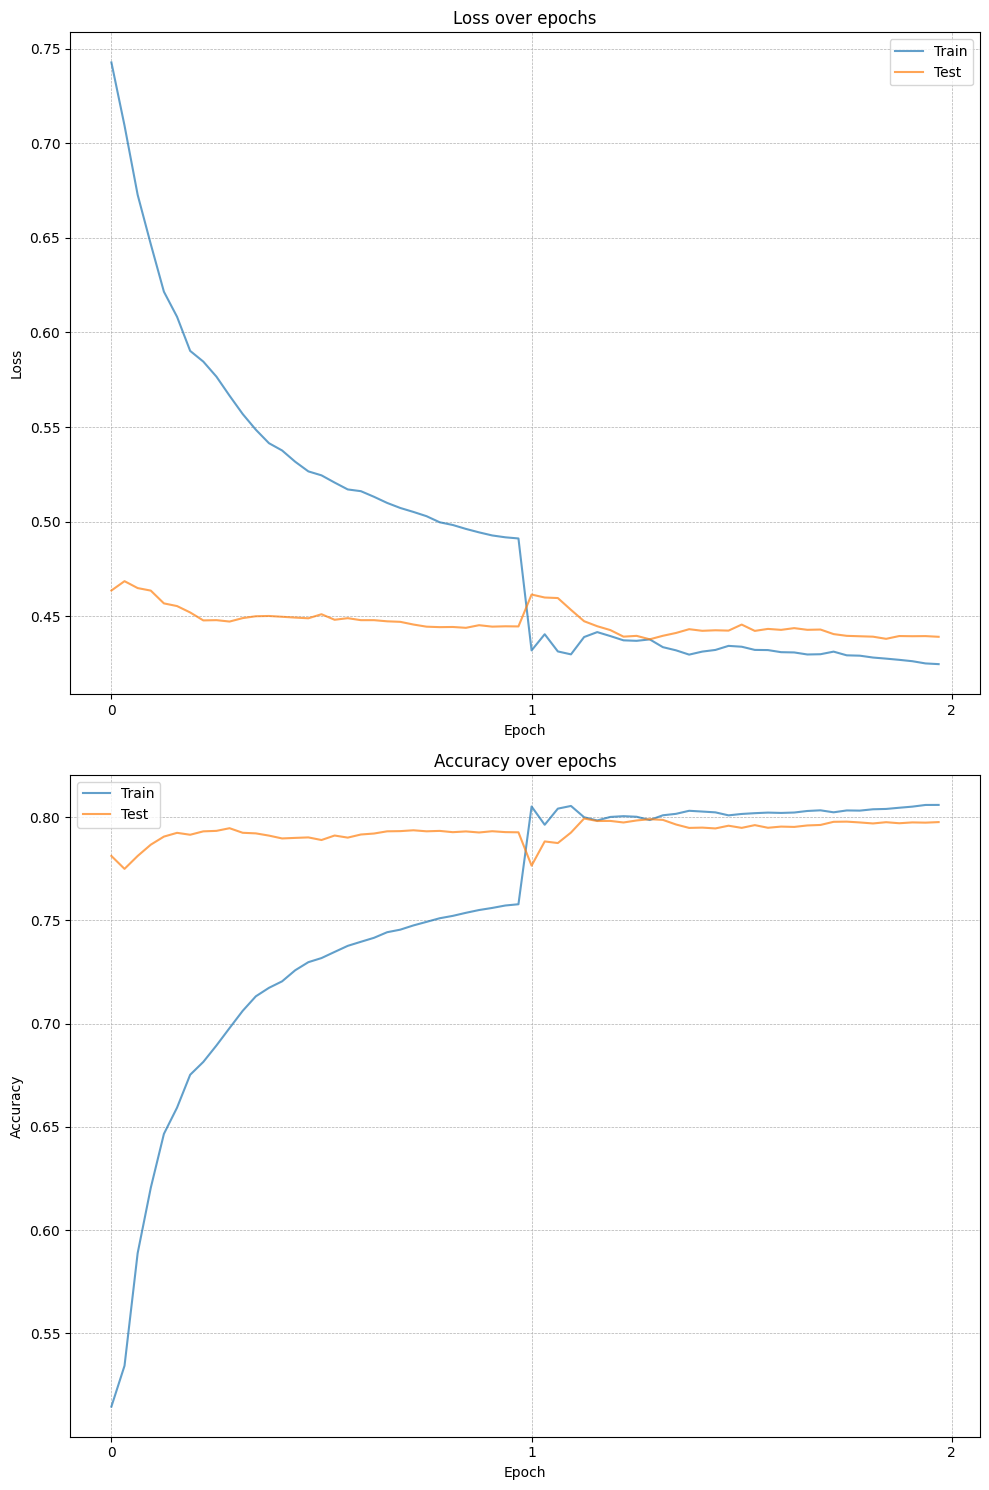

In [147]:
mlp = MLP(hidden_size=128).to(device)
mlp_metrics = train_model(mlp, train_dataloader, test_dataloader, 
                          optimizer=torch.optim.Adam(mlp.parameters(), lr=0.02), 
                          criterion=nn.CrossEntropyLoss(), 
                          num_epochs=2)


Epoch 1/5
Training MLP on cpu


Epoch 1/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cpu


Epoch 1/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.5252, Train Accuracy: 0.7372
Test Loss: 0.5014, Test Accuracy: 0.7519

Epoch 2/5
Training MLP on cpu


Epoch 2/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cpu


Epoch 2/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4576, Train Accuracy: 0.7871
Test Loss: 0.4556, Test Accuracy: 0.7889

Epoch 3/5
Training MLP on cpu


Epoch 3/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cpu


Epoch 3/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4400, Train Accuracy: 0.7953
Test Loss: 0.4426, Test Accuracy: 0.7952

Epoch 4/5
Training MLP on cpu


Epoch 4/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cpu


Epoch 4/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4281, Train Accuracy: 0.8044
Test Loss: 0.4455, Test Accuracy: 0.7917

Epoch 5/5
Training MLP on cpu


Epoch 5/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cpu


Epoch 5/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4173, Train Accuracy: 0.8094
Test Loss: 0.4263, Test Accuracy: 0.8030


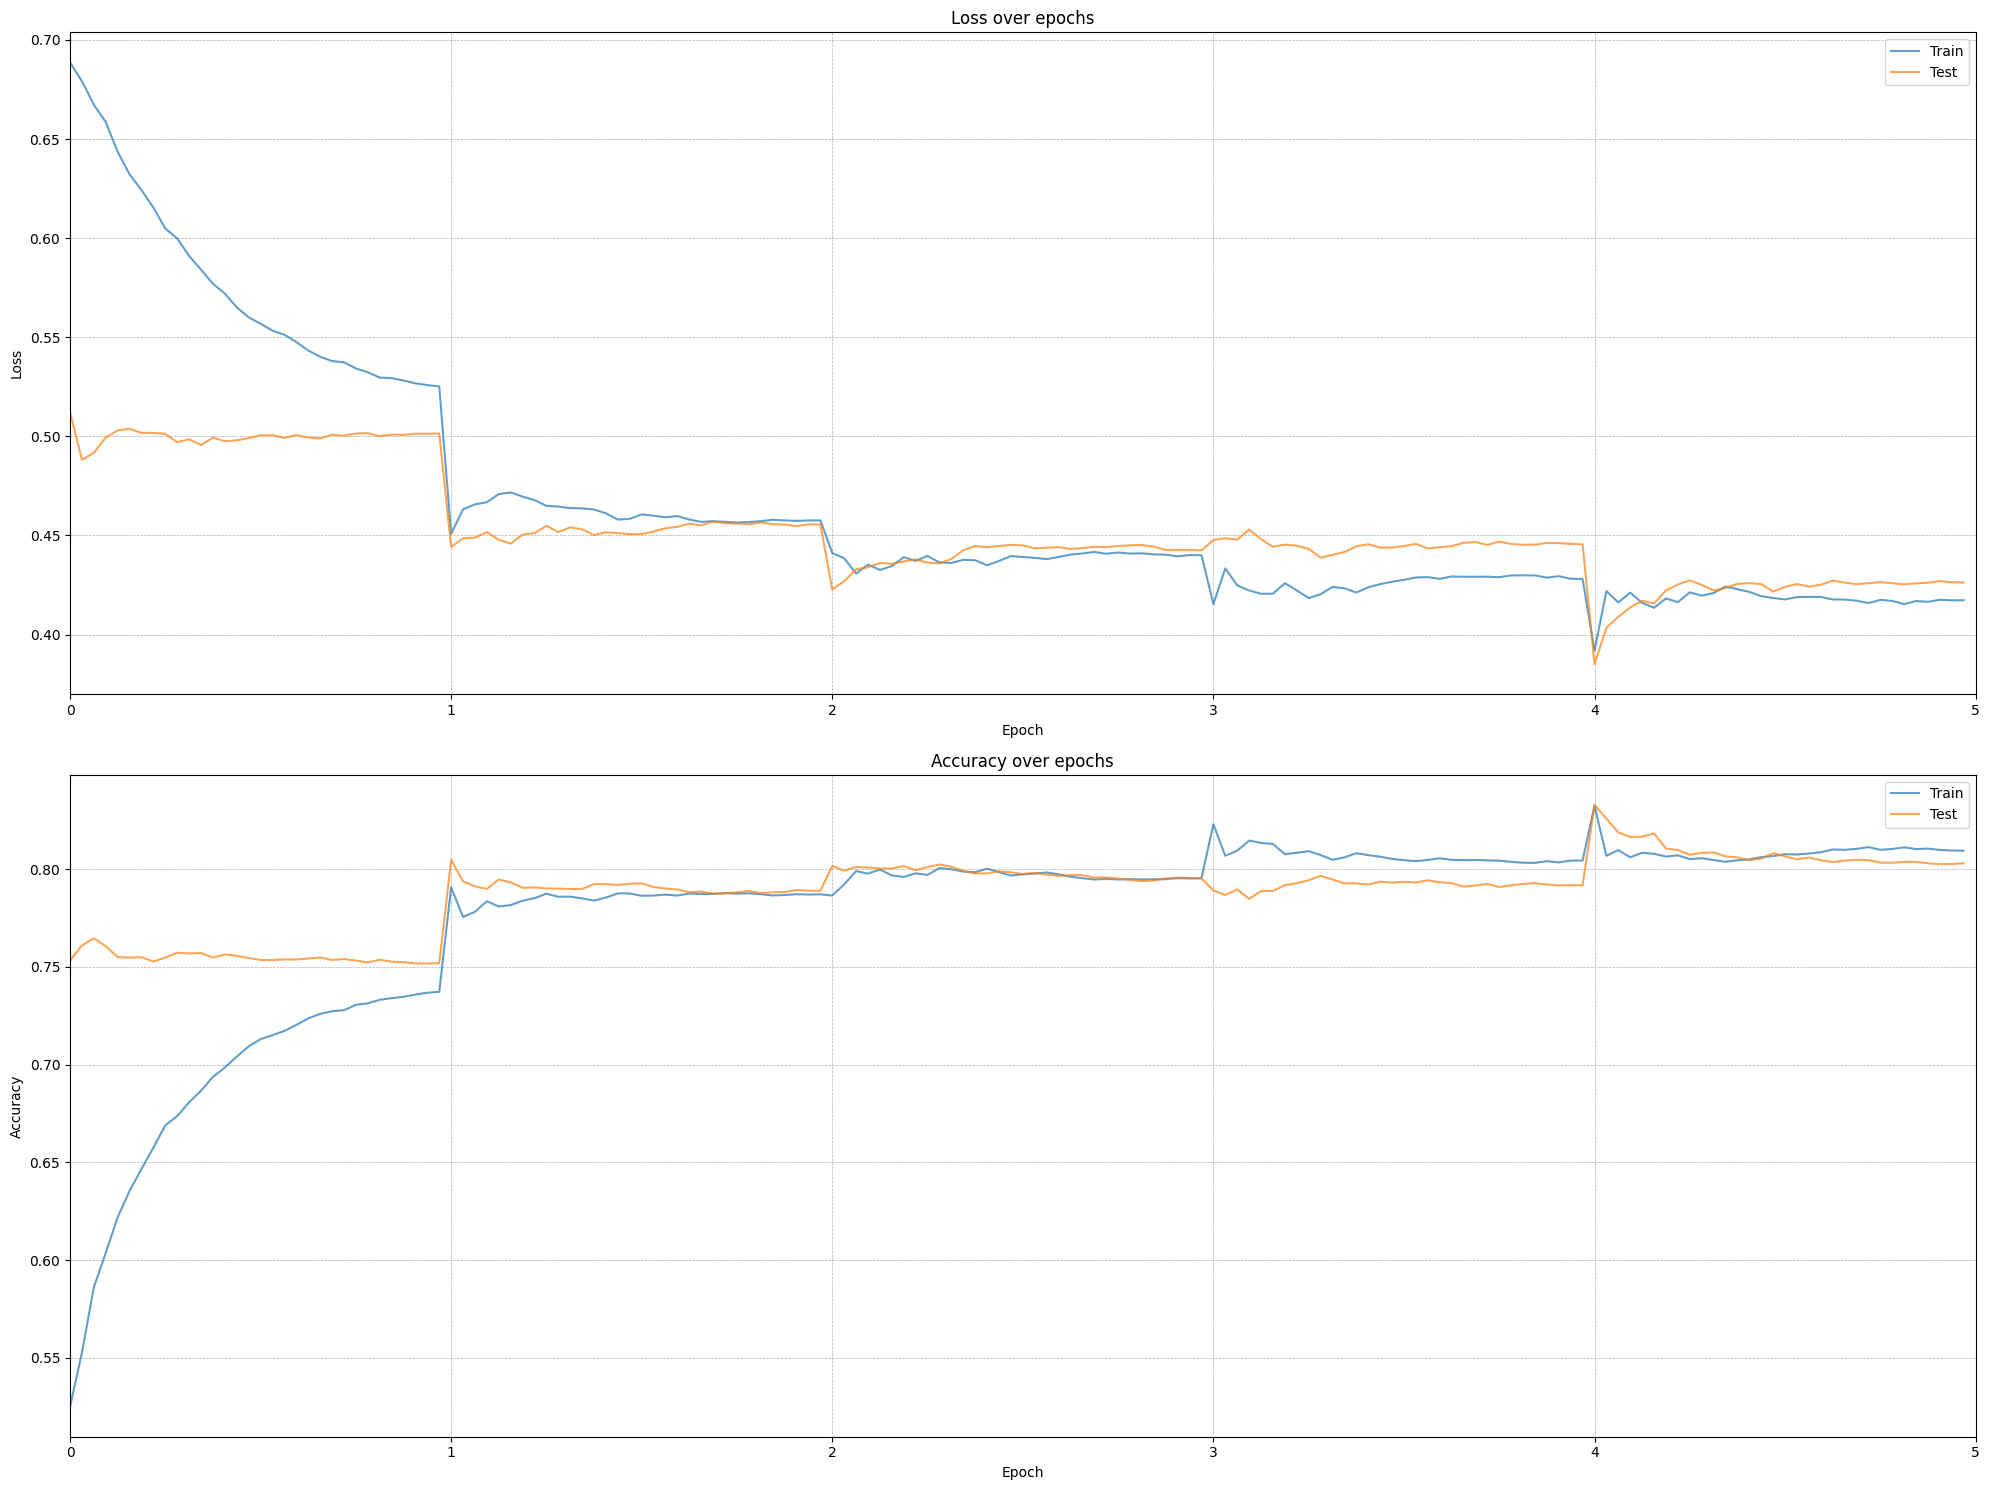

In [35]:
mlp64 = MLP(hidden_size=64).to(device)
mlp64_metrics = train_model(mlp64, train_dataloader, test_dataloader, 
                          optimizer=torch.optim.Adam(mlp64.parameters(), lr=0.005), 
                          criterion=nn.CrossEntropyLoss(), 
                          num_epochs=5)
torch.save(mlp64, mlp64.name() + '_64'+ ".pth")


Epoch 1/5
Training MLP on cpu


Epoch 1/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cpu


Epoch 1/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4992, Train Accuracy: 0.7580
Test Loss: 0.4490, Test Accuracy: 0.7884

Epoch 2/5
Training MLP on cpu


Epoch 2/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cpu


Epoch 2/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4298, Train Accuracy: 0.8051
Test Loss: 0.4282, Test Accuracy: 0.8040

Epoch 3/5
Training MLP on cpu


Epoch 3/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]


Training interrupted. Returning metrics collected so far.


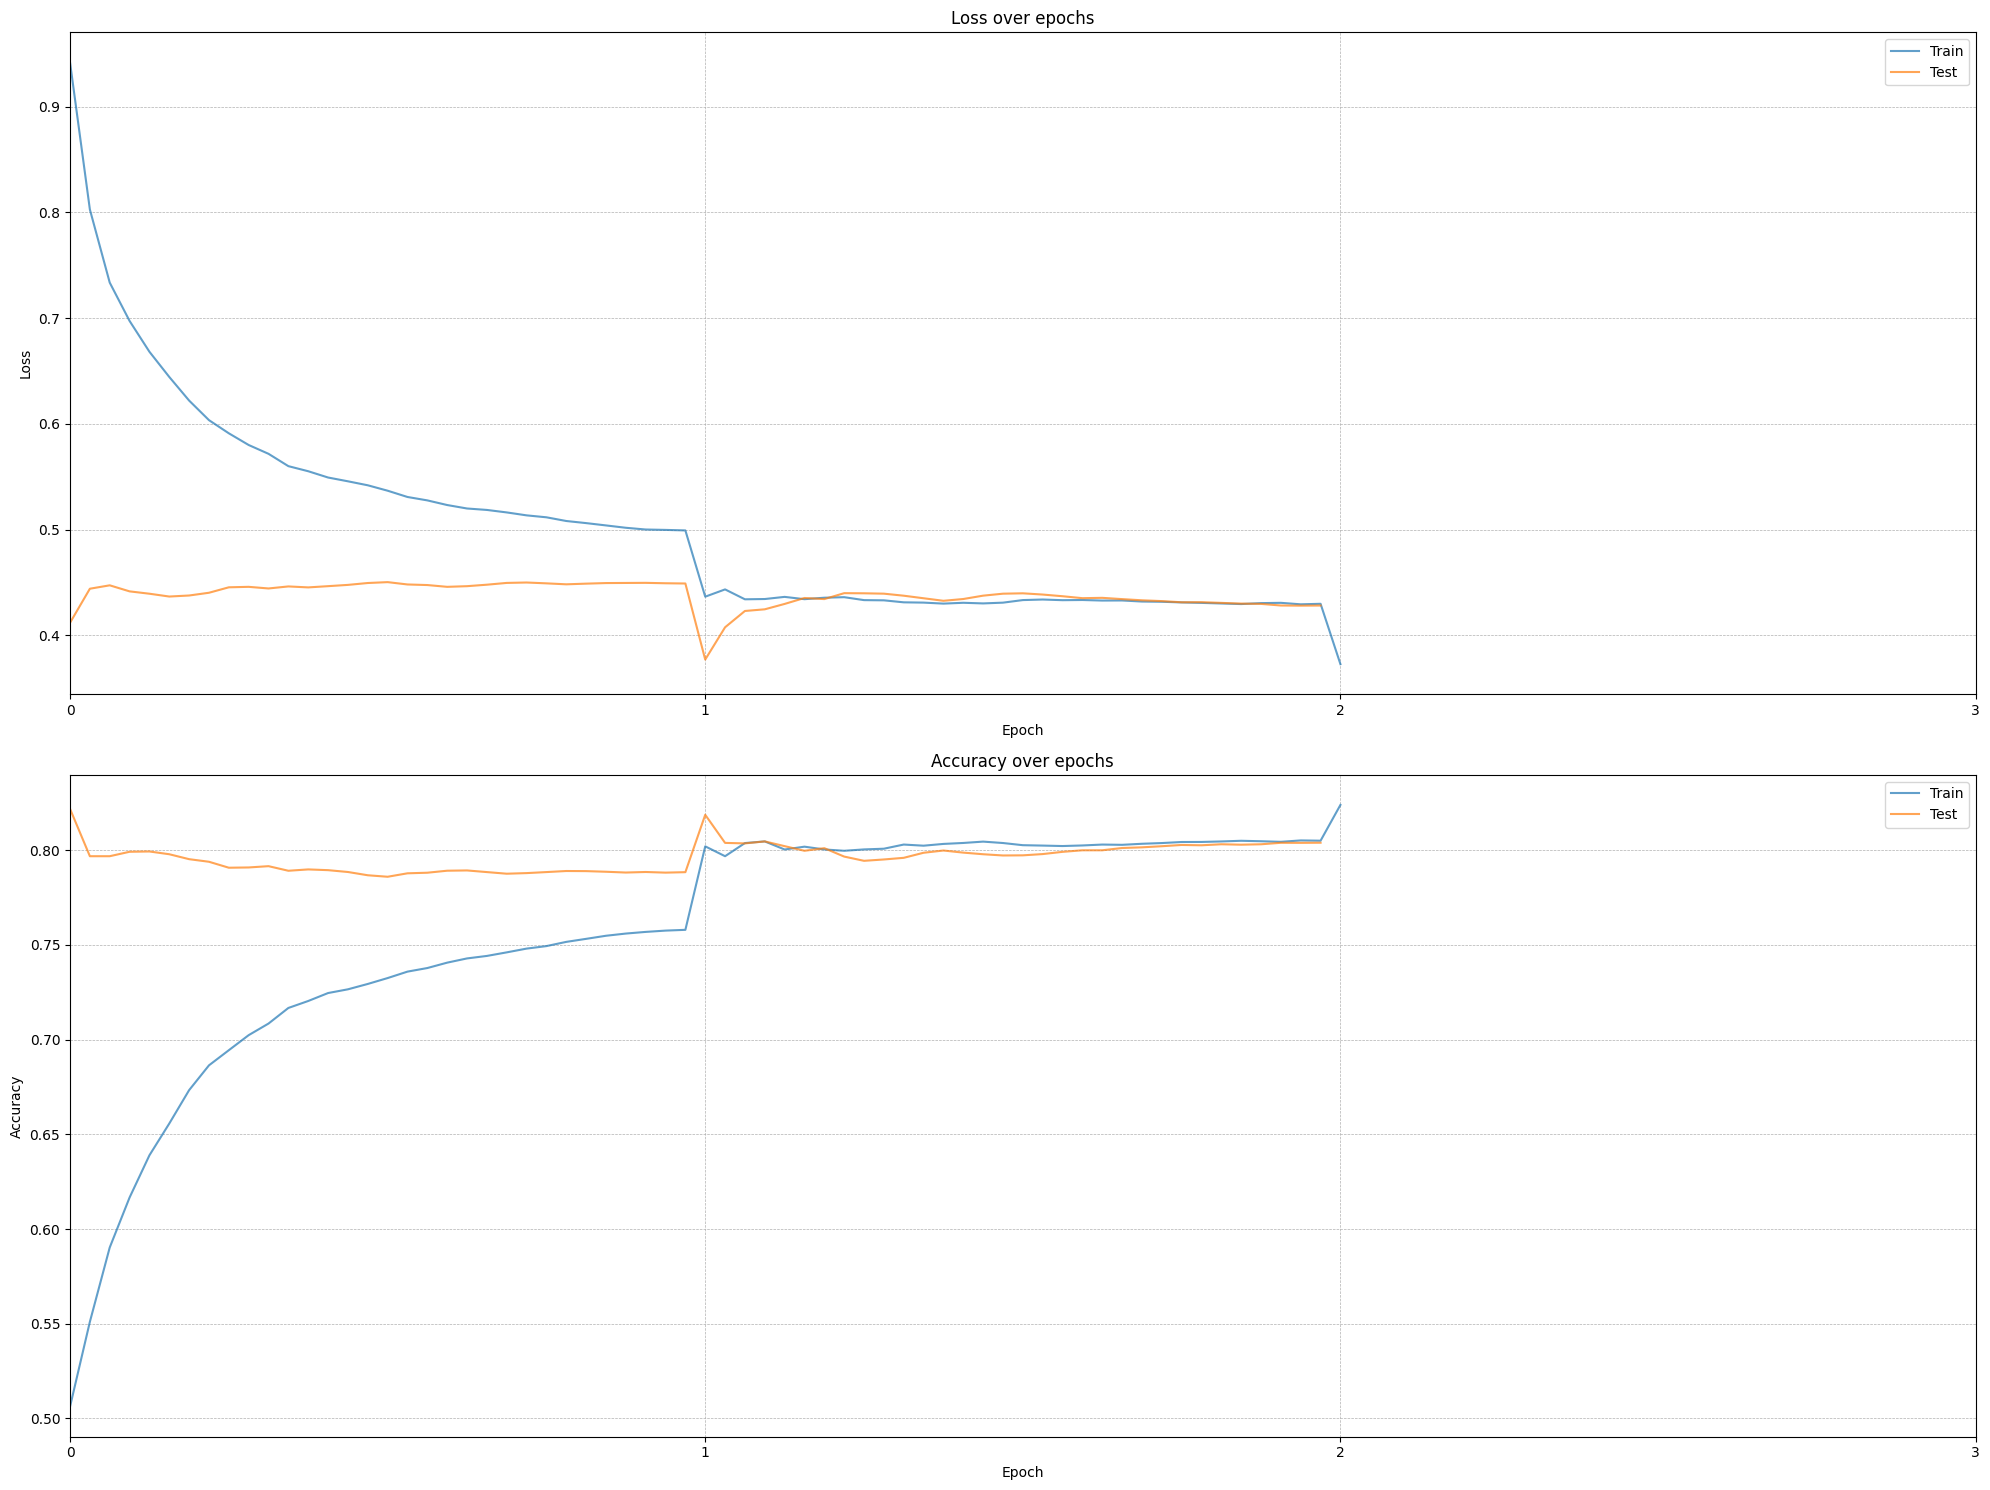

In [40]:
mlp128 = MLP(hidden_size=128).to(device)
mlp128_metrics = train_model(mlp128, train_dataloader, test_dataloader, 
                          optimizer=torch.optim.Adam(mlp128.parameters(), lr=0.05), 
                          criterion=nn.CrossEntropyLoss(), 
                          num_epochs=5)
torch.save(mlp128, mlp128.name() + '_128'+ ".pth")

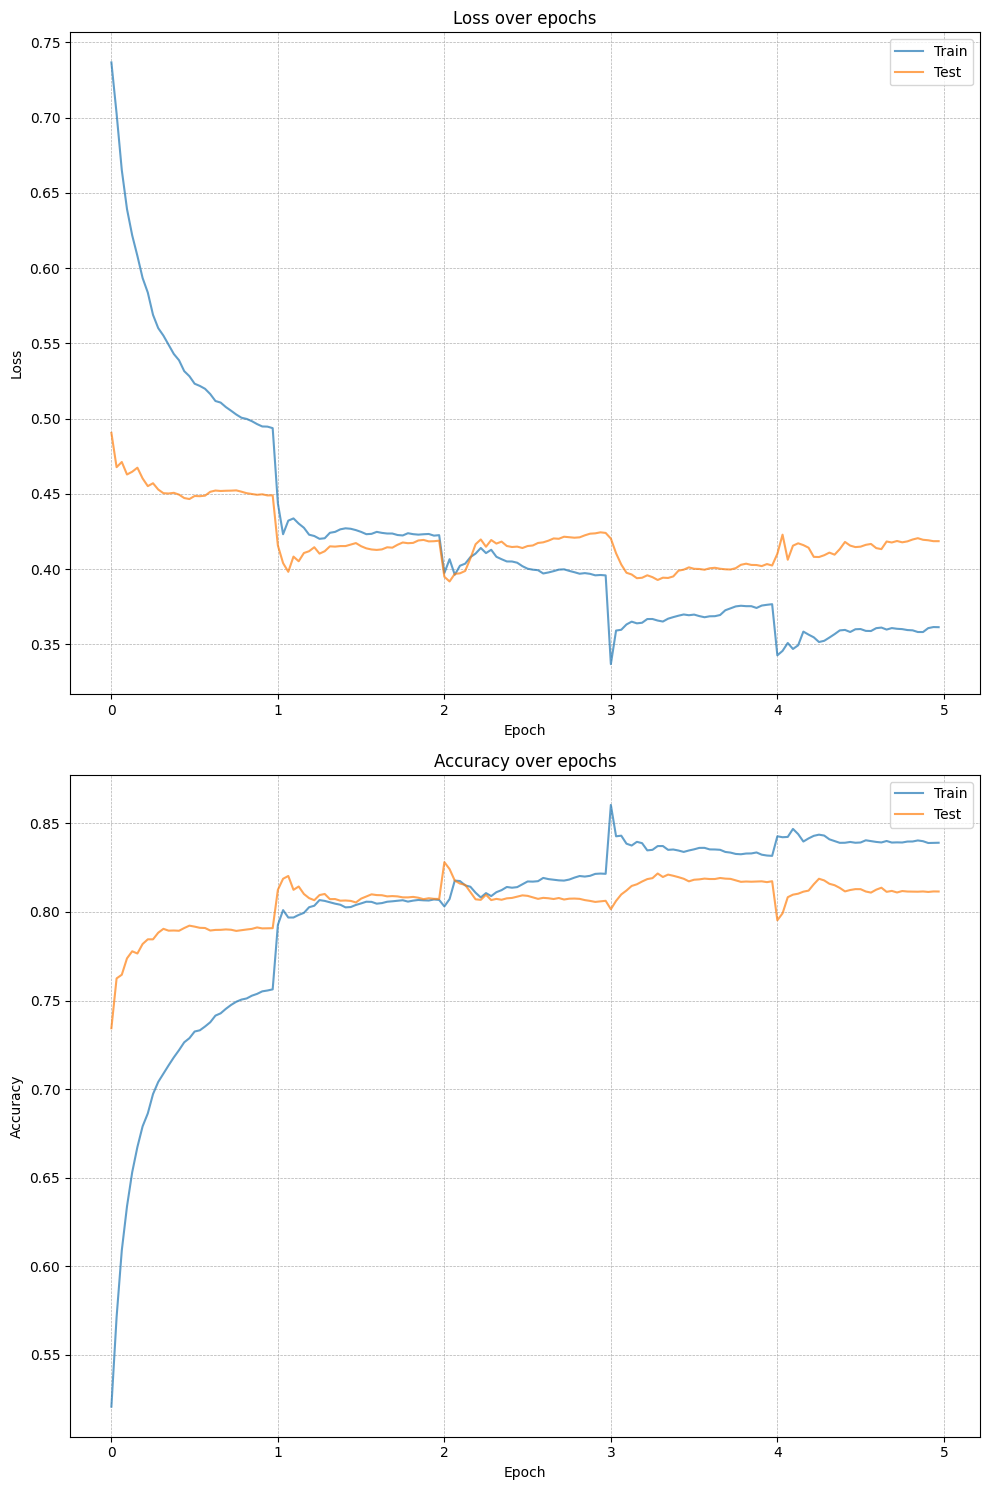

In [47]:
create_metric_plots(mlp_metrics, figsize=(10, 15))

# Self Attention

In [89]:
class MatMul(nn.Module):
    def __init__(self, in_channels, out_channels, use_bias=True):
        super(MatMul, self).__init__()
        self.matrix = torch.nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(in_channels, out_channels)), requires_grad=True)
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros(1, 1, out_channels), requires_grad=True)
        self.use_bias = use_bias

    def forward(self, x):
        x = torch.matmul(x, self.matrix)
        if self.use_bias:
            x = x + self.bias
        return x

class RestrictedSelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_size, window_size=5):
        super(RestrictedSelfAttention, self).__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.window_size = window_size
        self.sqrt_hidden_size = np.sqrt(float(hidden_size))
        
        self.W_q = MatMul(input_dim, hidden_size, use_bias=False)
        self.W_k = MatMul(input_dim, hidden_size, use_bias=False)
        self.W_v = MatMul(input_dim, hidden_size, use_bias=False)
        self.W_o = MatMul(hidden_size, input_dim, use_bias=False)  # Add this line

        self.layer_norm = nn.LayerNorm(input_dim)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        x = self.layer_norm(x)
        
        # Compute Q, K, V
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Prepare padded sequence for restricted attention
        padded_K = F.pad(K, (0, 0, self.window_size, self.window_size), mode='constant', value=0)
        padded_V = F.pad(V, (0, 0, self.window_size, self.window_size), mode='constant', value=0)
        
        # Initialize output tensor
        # output = torch.zeros_like(x)
        output = torch.zeros(batch_size, seq_len, self.hidden_size, device=x.device)
        atten_weights = torch.zeros(batch_size, seq_len, 2 * self.window_size + 1, device=x.device)

        
        for i in range(seq_len):
            # Extract window
            window_K = padded_K[:, i:i+2*self.window_size+1, :]
            window_V = padded_V[:, i:i+2*self.window_size+1, :]
            
            # Compute attention scores
            attention = torch.matmul(Q[:, i:i+1, :], window_K.transpose(-2, -1)) / self.sqrt_hidden_size
            
            # Apply softmax to get attention weights
            attention_weights = F.softmax(attention, dim=-1)
            atten_weights[:, i, :] = attention_weights.squeeze(1)
            
            # Compute weighted sum
            weighted_sum = torch.matmul(attention_weights, window_V)
            output[:, i:i+1, :] = weighted_sum
        
        return output, atten_weights

    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)] # (batch_size, sequence_length, d_model)

class SelfAttentionMLP(nn.Module):
    def __init__(self, input_size=100, hidden_size=64, window_size=5):
        super(SelfAttentionMLP, self).__init__()
        self.positional_encoding = PositionalEncoding(input_size)
        self.self_attention = RestrictedSelfAttention(input_size, hidden_size, window_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)
        )

    def name(self):
        return "SelfAttentionMLP"

    def train_step(self, inputs, targets, optimizer, criterion):
        optimizer.zero_grad()
        logits, _ = self(inputs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        return loss.item(), logits

    def validation_step(self, inputs, targets, criterion):
        logits, _ = self(inputs)
        loss = criterion(logits, targets)
        return loss.item(), logits

    def forward(self, x):
        x = self.positional_encoding(x)
        x, atten_weights = self.self_attention(x)
        sub_scores = self.mlp(x)  # (batch_size, seq_len, 2)
        scores = torch.mean(sub_scores, dim=1)  # (batch_size, 2)
        return scores, sub_scores



Epoch 1/10
Training SelfAttentionMLP on cpu


Epoch 1/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 1/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6929, Train Accuracy: 0.5053
Test Loss: 0.6903, Test Accuracy: 0.5395

Epoch 2/10
Training SelfAttentionMLP on cpu


Epoch 2/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 2/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6860, Train Accuracy: 0.5496
Test Loss: 0.6772, Test Accuracy: 0.5756

Epoch 3/10
Training SelfAttentionMLP on cpu


Epoch 3/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 3/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6718, Train Accuracy: 0.5899
Test Loss: 0.6632, Test Accuracy: 0.6048

Epoch 4/10
Training SelfAttentionMLP on cpu


Epoch 4/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 4/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6533, Train Accuracy: 0.6189
Test Loss: 0.6318, Test Accuracy: 0.6473

Epoch 5/10
Training SelfAttentionMLP on cpu


Epoch 5/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 5/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.5813, Train Accuracy: 0.6987
Test Loss: 0.5368, Test Accuracy: 0.7296

Epoch 6/10
Training SelfAttentionMLP on cpu


Epoch 6/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 6/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.5066, Train Accuracy: 0.7507
Test Loss: 0.4995, Test Accuracy: 0.7563

Epoch 7/10
Training SelfAttentionMLP on cpu


Epoch 7/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 7/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4828, Train Accuracy: 0.7677
Test Loss: 0.4867, Test Accuracy: 0.7622

Epoch 8/10
Training SelfAttentionMLP on cpu


Epoch 8/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 8/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4756, Train Accuracy: 0.7707
Test Loss: 0.4792, Test Accuracy: 0.7667

Epoch 9/10
Training SelfAttentionMLP on cpu


Epoch 9/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 9/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4688, Train Accuracy: 0.7752
Test Loss: 0.4788, Test Accuracy: 0.7671

Epoch 10/10
Training SelfAttentionMLP on cpu


Epoch 10/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 10/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4647, Train Accuracy: 0.7771
Test Loss: 0.4726, Test Accuracy: 0.7706


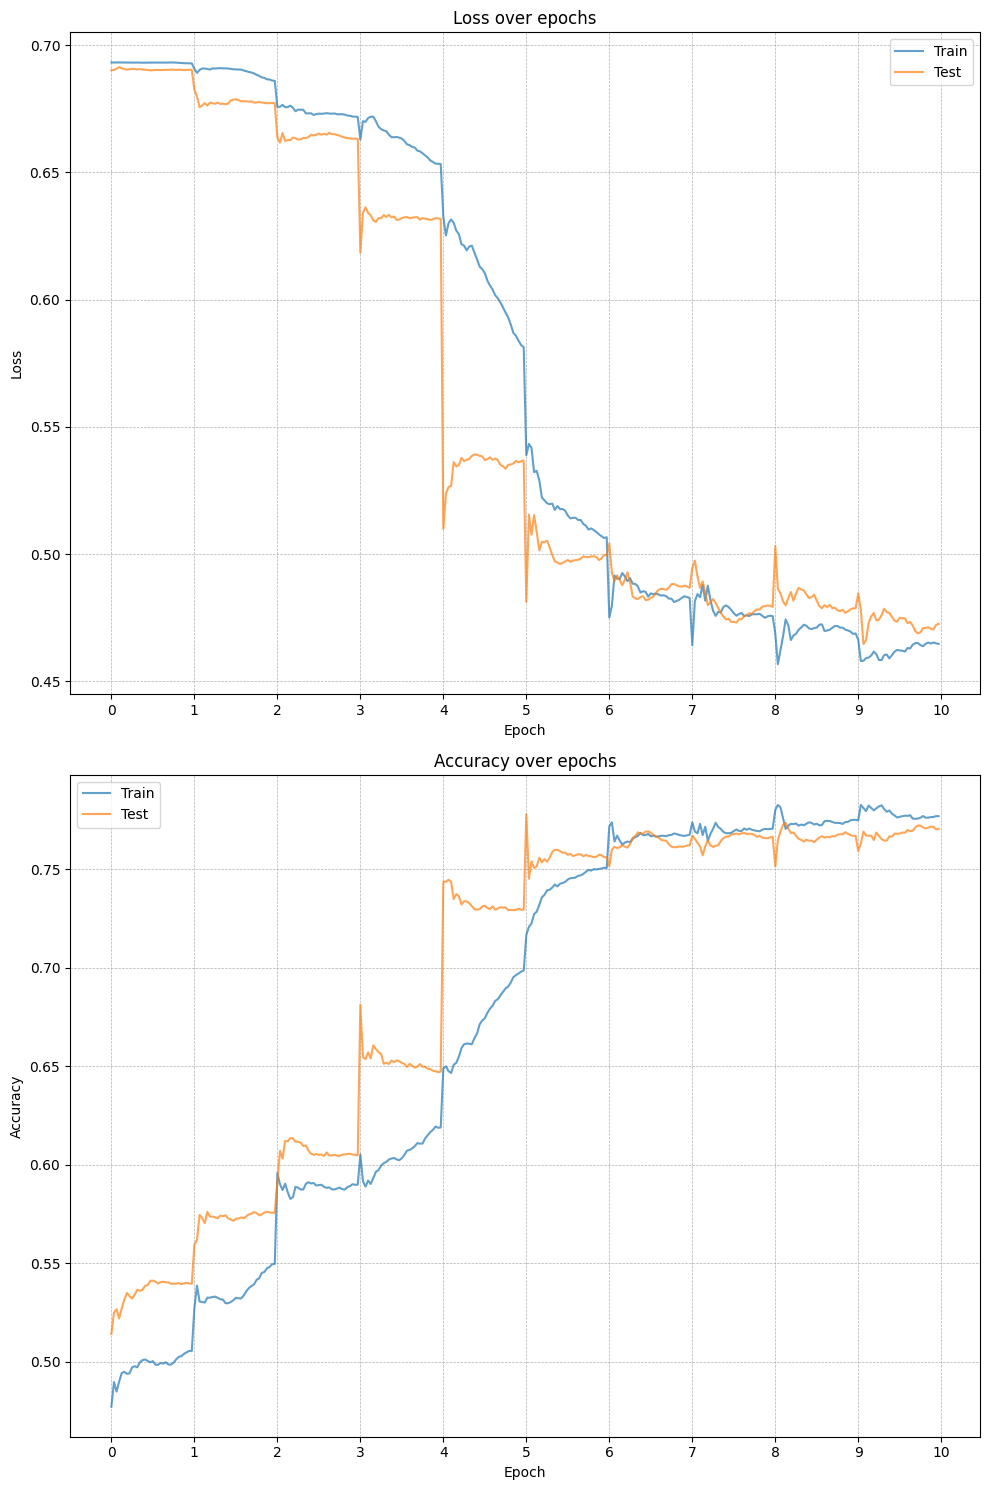

In [74]:
# Create and train the model
self_attention_mlp_ = SelfAttentionMLP(hidden_size=128).to(device)
self_attention_mlp_metrics_ = train_model(self_attention_mlp, train_dataloader, test_dataloader, 
                                         optimizer=torch.optim.Adam(self_attention_mlp.parameters(), lr=0.001), 
                                         criterion=nn.CrossEntropyLoss(), 
                                         num_epochs=10)



Epoch 1/10
Training SelfAttentionMLP on cpu


Epoch 1/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 1/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.5143, Train Accuracy: 0.7360
Test Loss: 0.4685, Test Accuracy: 0.7770

Epoch 2/10
Training SelfAttentionMLP on cpu


Epoch 2/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 2/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4530, Train Accuracy: 0.7842
Test Loss: 0.4508, Test Accuracy: 0.7894

Epoch 3/10
Training SelfAttentionMLP on cpu


Epoch 3/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 3/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4338, Train Accuracy: 0.7987
Test Loss: 0.4344, Test Accuracy: 0.7981

Epoch 4/10
Training SelfAttentionMLP on cpu


Epoch 4/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 4/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]


Training interrupted. Returning metrics collected so far.


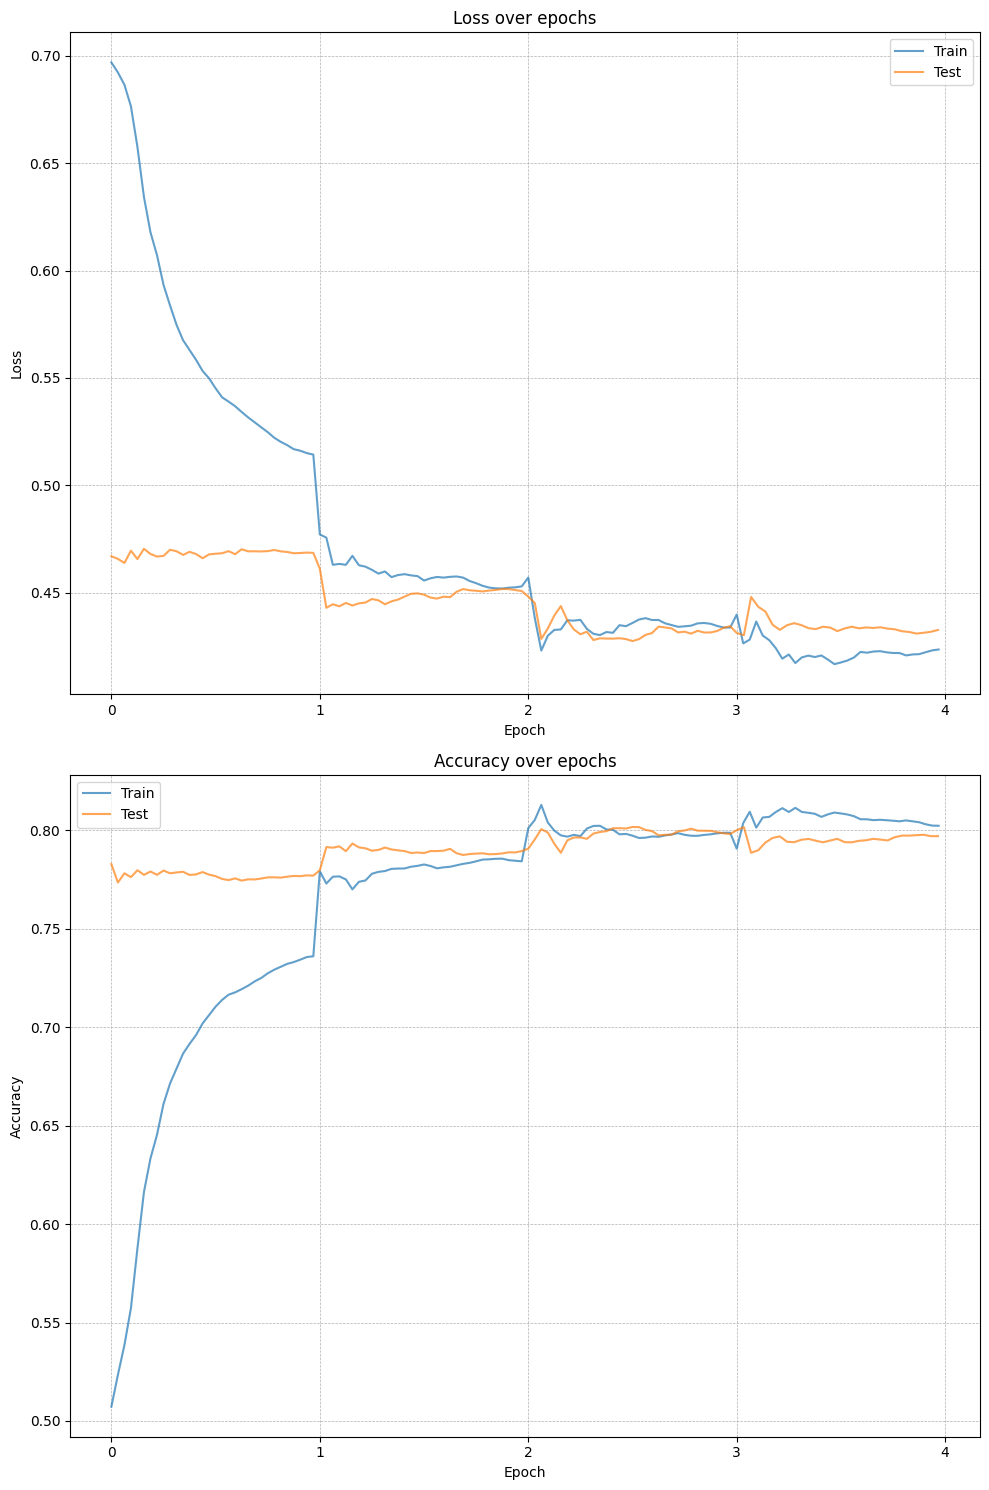

In [90]:
# Create and train the model
self_attention_mlp_pos = SelfAttentionMLP(hidden_size=128).to(device)
self_attention_mlp_metrics_pos = train_model(self_attention_mlp_pos, train_dataloader, test_dataloader, 
                                         optimizer=torch.optim.Adam(self_attention_mlp_pos.parameters(), lr=0.001), 
                                         criterion=nn.CrossEntropyLoss(), 
                                         num_epochs=10)

In [91]:
torch.save(self_attention_mlp_pos, self_attention_mlp_pos.name() + '_128'+ ".pth")


Epoch 1/10
Training SelfAttentionMLP on cpu


Epoch 1/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 1/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4055, Train Accuracy: 0.8130
Test Loss: 0.4336, Test Accuracy: 0.7974

Epoch 2/10
Training SelfAttentionMLP on cpu


Epoch 2/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]


Training interrupted. Returning metrics collected so far.


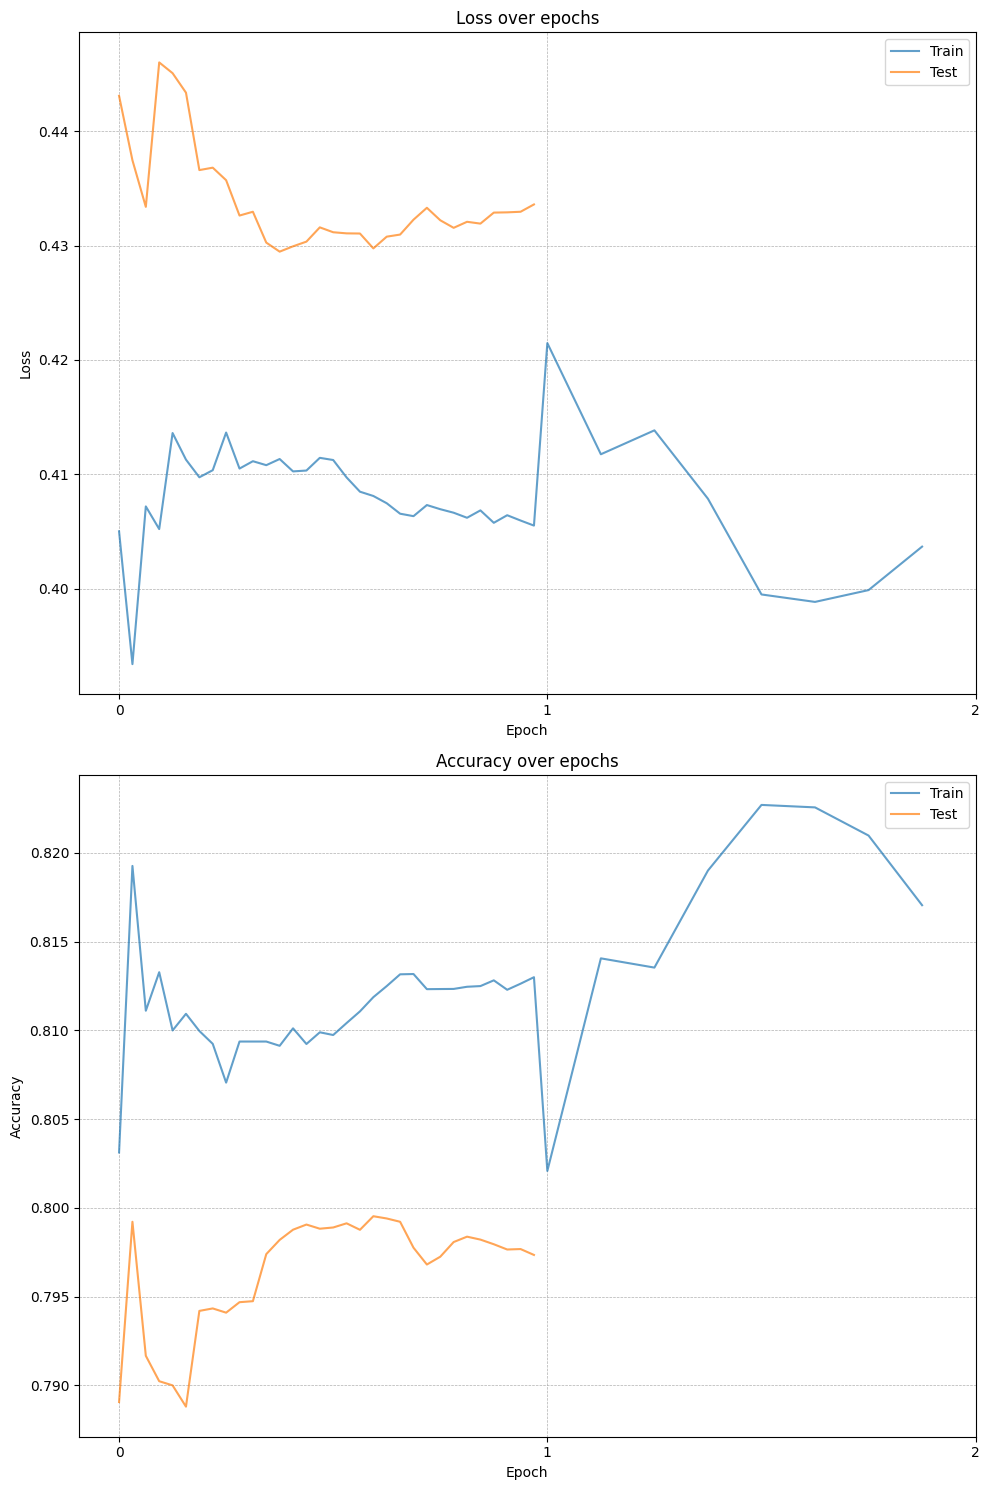

In [92]:
self_attention_mlp_metrics_pos_ext = train_model(self_attention_mlp_pos, train_dataloader, test_dataloader, 
                                         optimizer=torch.optim.Adam(self_attention_mlp_pos.parameters(), lr=0.0005), 
                                         criterion=nn.CrossEntropyLoss(), 
                                         num_epochs=10)


Epoch 1/10
Training SelfAttentionMLP on cpu


Epoch 1/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 1/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3875, Train Accuracy: 0.8229
Test Loss: 0.4235, Test Accuracy: 0.8028

Epoch 2/10
Training SelfAttentionMLP on cpu


Epoch 2/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 2/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]


Training interrupted. Returning metrics collected so far.


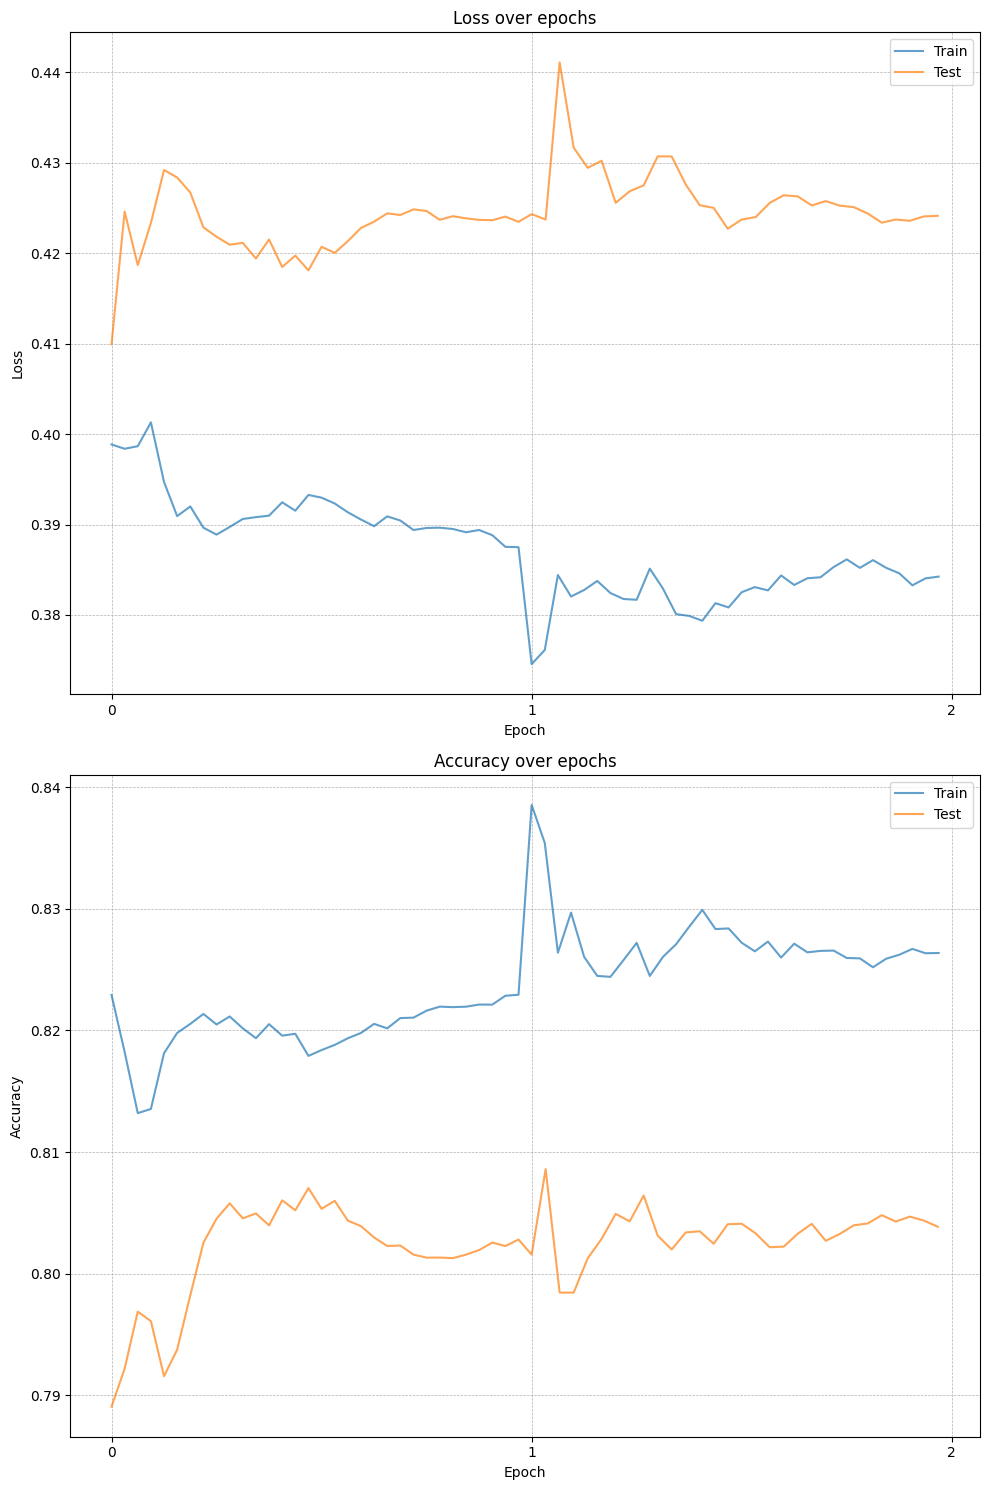

In [93]:
self_attention_mlp_metrics_pos_ext1 = train_model(self_attention_mlp_pos, train_dataloader, test_dataloader, 
                                         optimizer=torch.optim.Adam(self_attention_mlp_pos.parameters(), lr=0.0001), 
                                         criterion=nn.CrossEntropyLoss(), 
                                         num_epochs=10)


Epoch 1/10
Training SelfAttentionMLP on cpu


Epoch 1/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cpu


Epoch 1/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]


Training interrupted. Returning metrics collected so far.


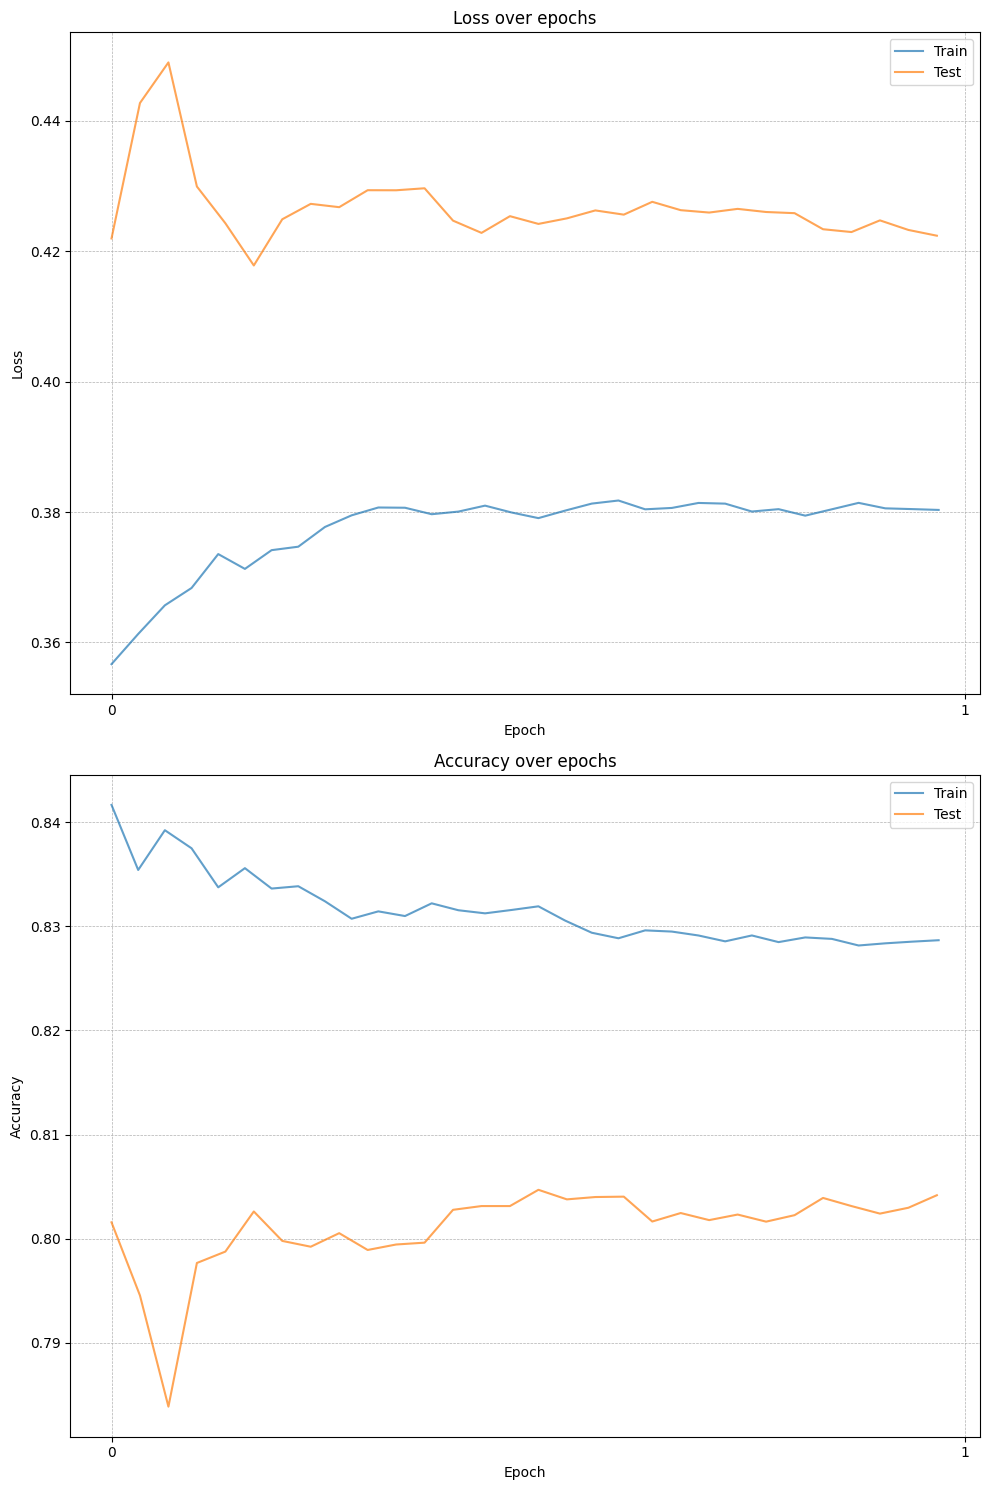

In [94]:
self_attention_mlp_metrics_pos_ext2 = train_model(self_attention_mlp_pos, train_dataloader, test_dataloader, 
                                         optimizer=torch.optim.Adam(self_attention_mlp_pos.parameters(), lr=0.00001), 
                                         criterion=nn.CrossEntropyLoss(), 
                                         num_epochs=10)

In [95]:
# torch.save(self_attention_mlp_pos, self_attention_mlp_pos.name() + '_128_epoch10'+ ".pth")

In [ ]:
self_attention_mlp_pos

# Testing

In [270]:
import torch
from collections import defaultdict
from torch.utils.data import DataLoader

class IndexedDataLoader:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.dataset = dataloader.dataset
        self.batch_size = dataloader.batch_size

    def __iter__(self):
        for batch_idx, (labels, embeddings, reviews) in enumerate(self.dataloader):
            start_index = batch_idx * self.batch_size
            indices = torch.arange(start_index, start_index + len(labels))
            yield indices, labels, embeddings, reviews

    def __len__(self):
        return len(self.dataset)

    def get_item(self, index):
        return self.dataset[index]

    
    def get_review_by_index(self, index):
        _, _, _, review = self.get_item(index)
        return ' '.join(review)
indexed_test_dataloader = IndexedDataLoader(test_dataloader)

In [122]:
def get_prediction_indices(model, indexed_dataloader, device):
    model.eval()
    tp_indices, tn_indices, fp_indices, fn_indices = set(), set(), set(), set()
    
    with torch.no_grad():
        for indices, labels, embeddings, _ in indexed_dataloader:
            labels, embeddings = labels.to(device), embeddings.to(device)
            outputs = model(embeddings)
            
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            
            predicted = outputs.argmax(dim=1)
            true_labels = labels.argmax(dim=1)
            
            for idx, pred, true_label in zip(indices, predicted, true_labels):
                idx = idx.item()
                if pred == 0 and true_label == 0:  # Positive
                    tp_indices.add(idx)
                elif pred == 1 and true_label == 1:  # Negative
                    tn_indices.add(idx)
                elif pred == 0 and true_label == 1:  # False Positive
                    fp_indices.add(idx)
                elif pred == 1 and true_label == 0:  # False Negative
                    fn_indices.add(idx)
    
    return {
        'TP': tp_indices,
        'TN': tn_indices,
        'FP': fp_indices,
        'FN': fn_indices
    }

def analyze_models(models, indexed_dataloader, device):
    results = {}
    for model_name, model in models.items():
        results[model_name] = get_prediction_indices(model, indexed_dataloader, device)
    return results

In [242]:
def format_output(logits):
    probs = F.softmax(torch.tensor(logits), dim=0)
    return [(f"{logit:.4f}", f"{prob:.4f}") for logit, prob in zip(logits, probs)]

def get_prediction_by_index(model, indexed_dataloader, index):
    # Directly access the underlying dataset
    return predict_raw_review(model, indexed_dataloader.dataset[index])


def predict_raw_review(model, raw_review):
    review, label = raw_review
    embedding = preprocess_review(review).to(device)
    print(embedding.shape)
    
    model.eval()
    with torch.no_grad():
        scores, sub_scores = model(embedding)        
        
        predicted = scores.argmax(dim=1).item()
    
    return {
        'review': review,
        'true_label': label.title(),
        'predicted_label': 'Positive' if predicted == 0 else 'Negative',
        'model_output': scores.squeeze().tolist(),
        'sub_scores': sub_scores.squeeze().tolist() if sub_scores is not None else None
    }

def display_prediction_with_sub_scores_by_index(model, indexed_dataloader, index, device):
    results = get_prediction_by_index(model, indexed_dataloader, index)
    display_prediction_with_sub_scores(results)

def display_prediction_with_sub_scores(results):
    from loader import tokinize
    print(f"Review (index {results.get('index', None)}):")
    print(results['review'])
    print(f"\nTokenized review: {' '.join(tokinize(results['review']))}")
    print(f"\nTrue label: {results['true_label']}")
    print(f"Predicted label: {results['predicted_label']}")

    print("\nOverall output:")
    overall_output = format_output(results['model_output'])
    print(f"Positive: {overall_output[0]}, Negative: {overall_output[1]}")

    if results['sub_scores'] is not None:
        print("\nSub-scores for each word:")
        for word, sub_score in zip(tokinize(results['review']), results['sub_scores']):
            word_output = format_output(sub_score)
            print(f"{word:<15}: Pos: {word_output[0]}, Neg: {word_output[1]}")

def analyze_specific_indices(models, indexed_dataloader, indices_to_check, device):
    for index in indices_to_check:
        print(f"\n{'='*50}")
        print(f"Checking index {index}:")
        for model_name, model in models.items():
            print(f"\nPrediction for {model_name}:")
            display_prediction_with_sub_scores_by_index(model, indexed_dataloader, index, device)


In [269]:
# Usage example
models = {
    'MLP': mlp,
    'SelfAttentionMLP': self_attention_mlp_pos
}
results = analyze_models(models, indexed_test_dataloader, device)

In [273]:
list(results['MLP']['TP'])[:5], list(results['MLP']['TN'])[:5]

([0, 3, 6, 11, 12], [1, 2, 4, 7, 9])

In [280]:
display_prediction_with_sub_scores(get_prediction_by_index(mlp, indexed_test_dataloader, 1))

torch.Size([1, 100, 100])
Review (index None):
This is one of the silliest movies I have ever had the misfortune to watch! I should have expected it, after seeing the first two, but I keep getting suckered into these types of movies with the idea of "Maybe they did it right this time". Nope - not even close.<br /><br />Where do I begin? How about with the special effects... To give you an idea of what passes for SFX in this movie, at one point a soldier is shooting at a "Raptor" as it runs down a hallway. Even with less than a second of screen time, the viewer can easily see that it is just a man with a tail apparently taped to him running around. Bad bad bad bad.<br /><br />How about the acting? If that's what you can call it. There is one character who, I suppose, is supposed to be from the south. However, after living in the south for six years now, I have never heard this way of talking. Perhaps he has some sort of weird disability - the inability to talk normally. I find it fascin

In [209]:
def compare_review_results(models, review, sentiment):
    for model_name, model in models.items():
        results = predict_raw_review(model, (review, sentiment))
        print(f"\nPrediction for {model_name}:")
        display_prediction_with_sub_scores(results)    

In [210]:
FP = "Although all the reviews praised the movie with high praises, I thought it was terrible"
compare_review_results(models, FP, 'negative')


Prediction for MLP:
Review (index None):
Although all the reviews praised the movie with high praises, I thought it was terrible

Tokenized review: although all the reviews praised the movie with high praises thought it was terrible

True label: Negative
Predicted label: Positive

Overall output:
Positive: ('-0.0010', '0.5169'), Negative: ('-0.0688', '0.4831')

Sub-scores for each word:
although       : Pos: ('0.2167', '0.6175'), Neg: ('-0.2623', '0.3825')
all            : Pos: ('0.6770', '0.7849'), Neg: ('-0.6173', '0.2151')
the            : Pos: ('0.2167', '0.6175'), Neg: ('-0.2623', '0.3825')
reviews        : Pos: ('-0.1929', '0.4235'), Neg: ('0.1153', '0.5765')
praised        : Pos: ('16.0305', '1.0000'), Neg: ('-16.6355', '0.0000')
the            : Pos: ('0.2167', '0.6175'), Neg: ('-0.2623', '0.3825')
movie          : Pos: ('0.2167', '0.6175'), Neg: ('-0.2623', '0.3825')
with           : Pos: ('0.7257', '0.7991'), Neg: ('-0.6549', '0.2009')
high           : Pos: ('0.6380', '0.774

In [278]:
TP = "Incredible movie, good actors, great screenplay, not bad at all"

In [279]:
compare_review_results(models, TP, 'positive')

torch.Size([1, 100, 100])

Prediction for MLP:
Review (index None):
Incredible movie, good actors, great screenplay, not bad at all

Tokenized review: incredible movie good actors great screenplay not bad at all

True label: Positive
Predicted label: Positive

Overall output:
Positive: ('0.3764', '0.6906'), Negative: ('-0.4266', '0.3094')

Sub-scores for each word:
incredible     : Pos: ('32.5958', '1.0000'), Neg: ('-31.6519', '0.0000')
movie          : Pos: ('0.2167', '0.6175'), Neg: ('-0.2623', '0.3825')
good           : Pos: ('8.8524', '1.0000'), Neg: ('-8.1958', '0.0000')
actors         : Pos: ('-6.6471', '0.0000'), Neg: ('7.8049', '1.0000')
great          : Pos: ('18.3527', '1.0000'), Neg: ('-17.7217', '0.0000')
screenplay     : Pos: ('-11.8131', '0.0000'), Neg: ('11.2654', '1.0000')
not            : Pos: ('0.2167', '0.6175'), Neg: ('-0.2623', '0.3825')
bad            : Pos: ('-41.6749', '0.0000'), Neg: ('41.2164', '1.0000')
at             : Pos: ('0.2167', '0.6175'), Neg: ('-0.26

In [281]:
hard_pos = "Although the choice of this subject by most directors will lead to a terrible movie, because of the complicated emotions the characters exhibit. This time it was not the case, a great, stunning and very good movie, I will remember this talented director."
compare_review_results(models, hard_pos, 'positive')

torch.Size([1, 100, 100])

Prediction for MLP:
Review (index None):
Although the choice of this subject by most directors will lead to a terrible movie, because of the complicated emotions the characters exhibit. This time it was not the case, a great, stunning and very good movie, I will remember this talented director.

Tokenized review: although the choice of this subject by most directors will lead to terrible movie because of the complicated emotions the characters exhibit this time it was not the case great stunning and very good movie will remember this talented director

True label: Positive
Predicted label: Positive

Overall output:
Positive: ('0.4530', '0.7111'), Negative: ('-0.4480', '0.2889')

Sub-scores for each word:
although       : Pos: ('0.2167', '0.6175'), Neg: ('-0.2623', '0.3825')
the            : Pos: ('0.2167', '0.6175'), Neg: ('-0.2623', '0.3825')
choice         : Pos: ('0.6318', '0.7775'), Neg: ('-0.6193', '0.2225')
of             : Pos: ('0.9738', '0.8606'), Ne

In [257]:
FN = "The movie perfectly depicted the harsh and cruel reality of life in the favelas, I was so immersed I felt like I was there. I couldn't stop crying from how good it was."

FN = "I usually don't like movies that depict the harsh reality of life, but this one was so well made I couldn't stop crying."

FN = "People with no eyes for art will not appreciate this movie, they will say it is trash,but it's a masterpiece"

FN = "The movie is not bad it is actually terrible, if you don't have eyes and can't appreciate brilliance, masterpiece at display, I couldn't stop crying, it was so good"
"We are faced with all the suffering and terrible consequences this place has to offer, however the main character has a dream of leaving, brilliant piece of art, incredibly touching and moving I couldn't stop crying"


FN = 'The brilliant actors: johnny dep, morgan freeman, angelina jolie, the amazing leonardo dicaprio, and brad pit mad the movie even though the screenplay was pretty terrible'
compare_review_results(models, FN, 'positive')


torch.Size([1, 100, 100])

Prediction for MLP:
Review (index None):
The brilliant actors: johnny dep, morgan freeman, angelina jolie, the amazing leonardo dicaprio, and brad pit mad the movie even though the screenplay was pretty terrible

Tokenized review: the brilliant actors johnny dep morgan freeman angelina jolie the amazing leonardo dicaprio and brad pit mad the movie even though the screenplay was pretty terrible

True label: Positive
Predicted label: Negative

Overall output:
Positive: ('-0.0390', '0.4965'), Negative: ('-0.0248', '0.5035')

Sub-scores for each word:
the            : Pos: ('0.2167', '0.6175'), Neg: ('-0.2623', '0.3825')
brilliant      : Pos: ('36.1377', '1.0000'), Neg: ('-36.2137', '0.0000')
actors         : Pos: ('-6.6471', '0.0000'), Neg: ('7.8049', '1.0000')
johnny         : Pos: ('2.3190', '0.9866'), Neg: ('-1.9765', '0.0134')
dep            : Pos: ('7.4481', '1.0000'), Neg: ('-8.4513', '0.0000')
morgan         : Pos: ('-0.0926', '0.4314'), Neg: ('0.1836', '

In [286]:
FN = "The movie is not bad it is actually terrible, if you don't have eyes and can't appreciate brilliance, masterpiece at display, I couldn't stop crying, it was so good"
FN = "I usually like movies with jim carrey, but this one just didn't do it for me."
compare_review_results(models, FN, 'negative')

torch.Size([1, 100, 100])

Prediction for MLP:
Review (index None):
I usually like movies with jim carrey, but this one just didn't do it for me.

Tokenized review: i usually like movies with jim carrey but this one just didn do it for me

True label: Negative
Predicted label: Positive

Overall output:
Positive: ('0.3551', '0.6830'), Negative: ('-0.4126', '0.3170')

Sub-scores for each word:
i              : Pos: ('0.2167', '0.6175'), Neg: ('-0.2623', '0.3825')
usually        : Pos: ('0.4219', '0.6716'), Neg: ('-0.2935', '0.3284')
like           : Pos: ('0.2167', '0.6175'), Neg: ('-0.2623', '0.3825')
movies         : Pos: ('2.3396', '0.9880'), Neg: ('-2.0753', '0.0120')
with           : Pos: ('0.7257', '0.7991'), Neg: ('-0.6549', '0.2009')
jim            : Pos: ('-0.0274', '0.5054'), Neg: ('-0.0491', '0.4946')
carrey         : Pos: ('0.9331', '0.7807'), Neg: ('-0.3367', '0.2193')
but            : Pos: ('0.2167', '0.6175'), Neg: ('-0.2623', '0.3825')
this           : Pos: ('0.2167', '0.

In [187]:
MLP_FN_ATTEN_TP = list(results['MLP']['FN'].intersection(results['SelfAttentionMLP']['TP']))
MLP_FP_ATTEN_TN = list(results['MLP']['FP'].intersection(results['SelfAttentionMLP']['TN']))

In [188]:
MLP_FN_ATTEN_TP_examples =sorted(MLP_FN_ATTEN_TP)[:5]
MLP_FP_ATTEN_TN_examples = sorted(MLP_FP_ATTEN_TN)[:5]
print(MLP_FN_ATTEN_TP_examples, MLP_FP_ATTEN_TN_examples)

[8, 13, 15, 17, 18] [5, 329, 752, 1135, 1180]


In [169]:
analyze_specific_indices(models, indexed_test_dataloader, MLP_FN_ATTEN_TP_examples, device)

In [ ]:
analyze_specific_indices(models, indexed_test_dataloader, MLP_FP_ATTEN_TN_examples, device)

In [ ]:
def calculate_confidence_scores(outputs, true_labels):
    probabilities = F.softmax(outputs, dim=1)
    predicted_labels = outputs.argmax(dim=1)
    correct_mask = (predicted_labels == true_labels)
    
    confidence_scores = probabilities.gather(1, true_labels.unsqueeze(1)).squeeze(1)
    confidence_scores = torch.where(correct_mask, confidence_scores, 1 - confidence_scores)
    
    return confidence_scores

In [267]:
import torch
import numpy as np
from tqdm.auto import tqdm

def find_divergent_examples(models, indexed_dataloader, device, top_k=10):
    mlp_model = models['MLP']
    attention_model = models['SelfAttentionMLP']
    
    mlp_incorrect = []
    attention_correct = []
    
    for indices, labels, embeddings, _ in tqdm(indexed_dataloader):
        indices, labels, embeddings = indices.to(device), labels.to(device), embeddings.to(device)
        true_labels = labels.argmax(dim=1)
        
        with torch.no_grad():
            mlp_outputs = mlp_model(embeddings)
            attention_outputs = attention_model(embeddings)
            
            if isinstance(mlp_outputs, tuple):
                mlp_outputs = mlp_outputs[0]
            if isinstance(attention_outputs, tuple):
                attention_outputs = attention_outputs[0]
            
            mlp_preds = mlp_outputs.argmax(dim=1)
            attention_preds = attention_outputs.argmax(dim=1)
            
            mlp_probs = torch.softmax(mlp_outputs, dim=1)
            attention_probs = torch.softmax(attention_outputs, dim=1)
            
            mlp_scores = mlp_probs[torch.arange(len(true_labels)), true_labels]
            attention_scores = attention_probs[torch.arange(len(true_labels)), true_labels]
            
            mlp_incorrect.extend([(idx.item(), score.item(), label.item()) 
                                  for idx, score, label in zip(indices[mlp_preds != true_labels], 
                                                               mlp_scores[mlp_preds != true_labels],
                                                               true_labels[mlp_preds != true_labels])])
            
            attention_correct.extend([(idx.item(), score.item(), label.item()) 
                                      for idx, score, label in zip(indices[attention_preds == true_labels], 
                                                                   attention_scores[attention_preds == true_labels],
                                                                   true_labels[attention_preds == true_labels])])
    
    # Convert to numpy arrays for faster operations
    mlp_incorrect = np.array(mlp_incorrect)
    attention_correct = np.array(attention_correct)
    
    # Find indices present in both arrays
    common_indices = np.intersect1d(mlp_incorrect[:, 0], attention_correct[:, 0])
    
    # Filter arrays to keep only common indices
    mlp_filtered = mlp_incorrect[np.isin(mlp_incorrect[:, 0], common_indices)]
    attention_filtered = attention_correct[np.isin(attention_correct[:, 0], common_indices)]
    
    # Sort both arrays by index for easier comparison
    mlp_filtered = mlp_filtered[mlp_filtered[:, 0].argsort()]
    attention_filtered = attention_filtered[attention_filtered[:, 0].argsort()]
    
    # Calculate divergence
    divergence = attention_filtered[:, 1] - mlp_filtered[:, 1]
    
    # Split into positive and negative examples
    pos_mask = attention_filtered[:, 2] == 0
    neg_mask = attention_filtered[:, 2] == 1
    
    # Get top k for positive and negative
    top_divergent_pos = attention_filtered[pos_mask, 0][np.argsort(divergence[pos_mask])[-top_k:]].astype(int)
    top_divergent_neg = attention_filtered[neg_mask, 0][np.argsort(divergence[neg_mask])[-top_k:]].astype(int)
    
    return top_divergent_pos.tolist(), top_divergent_neg.tolist()

# Usage
models = {
    'MLP': mlp,
    'SelfAttentionMLP': self_attention_mlp_pos
}

top_divergent_pos, top_divergent_neg = find_divergent_examples(models, indexed_test_dataloader, device, top_k=10)
print(top_divergent_pos, top_divergent_neg)

  0%|          | 0/20000 [00:00<?, ?it/s]

[14547, 11422, 11488, 1735, 14891, 5436, 9721, 3957, 7887, 16710] [9520, 11999, 7218, 1434, 14849, 13833, 6035, 8401, 13524, 2478]


In [204]:
[top_divergent_neg[0]]

[9520]

In [268]:
analyze_specific_indices(models, indexed_test_dataloader, top_divergent_neg, device)


Checking index 9520:

Prediction for MLP:
torch.Size([1, 100, 100])
Review (index None):
Cecil B. deMille's 1922 parlor-to-prison tearjerker Manslaughter finds the lovely Leatrice Joy as a good-at-heart but decadent young lady with more money than she knows what to do with. Her recklessness leads to imprisonment, which in turn leads to her regeneration. Thomas Meighan is the crusading district attorney who has made it his personal crusade to bring out the goodness and wholesomeness in Lydia (Joy) but he gets sidetracked by alcohol and once she is released, it is up to her to rescue him!<br /><br />If the plot doesn't sound too bad, you'll be floored by the woeful presentation. The quality of deMille's direction is very low, and he does not show any particular skill that is unique to him. The photography is standard and flat, and the editing is hardly more dynamic. One could easily classify it as a fashion show and be pretty correct. DeMille gets to dress Miss Joy up in so many differe

In [178]:
top_divergent_pos2

[1556, 18338, 530, 10676, 11840]

In [ ]:
FP = "Although all the reviews praised the movie with high praises, I thought it was terrible"
preprocess_review(FP)

In [179]:
analyze_specific_indices(models, indexed_test_dataloader, top_divergent_pos2, device)


Checking index 1556:

Prediction for MLP:
Review (index 1556):
Many neglect that this isn't just a classic due to the fact that it's the first 3D game, or even the first shoot-'em-up. It's also one of the first stealth games, one of the only(and definitely the first) truly claustrophobic games, and just a pretty well-rounded gaming experience in general. With graphics that are terribly dated today, the game thrusts you into the role of B.J.(don't even *think* I'm going to attempt spelling his last name!), an American P.O.W. caught in an underground bunker. You fight and search your way through tunnels in order to achieve different objectives for the six episodes(but, let's face it, most of them are just an excuse to hand you a weapon, surround you with Nazis and send you out to waste one of the Nazi leaders). The graphics are, as I mentioned before, quite dated and very simple. The least detailed of basically any 3D game released by a professional team of creators. If you can get over

In [153]:
analyze_specific_indices(models, indexed_test_dataloader, examples_to_check, device)


Checking index 8:

Prediction for MLP:
Review (index 8):
london young orphan named susan trinder sally hawkins grows up amongst the petty thieves known as fingersmiths under the guidance of mrs suckerby imelda staunton br br one evening richard the gentleman rivers rupert evans pays them visit br br rivers has an elaborate plan to defraud the wealthy heiress maud lilly elaine cassidy br br susan agrees to help for cut of the money and is quickly installed as muad maid br br upon arriving she discovers that maud is virtually prisoner in her own house as uncle chritopher charles dance controls every detail of her life br br

True label: Positive
Predicted label: Negative

Overall output:
Positive: ('-0.5223', '0.2664'), Negative: ('0.4905', '0.7336')

Sub-scores for each word:
london         : Pos: ('3.1964', '0.9983'), Neg: ('-3.1852', '0.0017')
young          : Pos: ('0.7463', '0.8049'), Neg: ('-0.6708', '0.1951')
orphan         : Pos: ('4.0347', '0.9998'), Neg: ('-4.4595', '0.0002')
